## Load libraries

In [1]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import itertools as it

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
%matplotlib inline

#neural network
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout
from keras.layers import GaussianNoise
from keras.callbacks import EarlyStopping
import seaborn as sns

sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)
np.set_printoptions(precision=2)

/Users/Grace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data Cleaning

In [2]:
def LD_data_cleaning(df):
    
    # transform date
    dt_cols = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']
    df[dt_cols] = df[dt_cols].apply(pd.to_datetime, errors = 'coerce')
    
    df['issue_month'] = pd.DatetimeIndex(df['issue_d']).month
    df['issue_month'] = df['issue_month'].apply(lambda x: calendar.month_abbr[x])
    df['earliest_cr_year'] = pd.DatetimeIndex(df['earliest_cr_line']).year
    
    drop_cols = ["issue_d","earliest_cr_line", # extract the issue month and earliest credit year
                 "issue_month",'addr_state', "zip_code", # seems less important 
                                                         # might potentially impact the validation 
                                                         # of random forest
                 # columns related to the outcome
                 # unavialable information before the loan accepted
                 "last_pymnt_d","last_credit_pull_d",
                 "initial_list_status","out_prncp_inv",
                 "total_pymnt_inv","last_pymnt_amnt",
                 "total_pymnt", "funded_amnt", "installment", 
                 "total_rec_prncp","out_prncp",
                 
                 
                 # highly correlated to some other existing columns
                 "num_rev_tl_bal_gt_0",
                 "tot_cur_bal",
                 "tot_hi_cred_lim",
                 "total_bc_limit"]
    
    # transform employment year
    emp_length_dict = {"10+":4, '2':1, '3':1, '4':2, '5':2, '6':2, '7':3, '8':3,'9':3, '< 1 year':1}
    df = df.replace({"emp_length": emp_length_dict})
    
    df = df.drop(drop_cols, axis = 1)
    
    dummy_cols = ['grade',
                  'disbursement_method',
                  'emp_length',
                  'home_ownership',
                  'purpose',
                  'application_type',
                  'hardship_flag', 
                  'debt_settlement_flag',
                  'loan_status']
    
    #scale the non-binary covariates
    nonbinary_cols = df.columns.difference(dummy_cols)
    scaler = StandardScaler().fit(df[nonbinary_cols])
    df[nonbinary_cols] = scaler.transform(df[nonbinary_cols])
    
    df_train, df_test = train_test_split(df, test_size=.5, 
                                         stratify=df[['loan_status']],
                                         random_state=123)
    
    df_train = pd.get_dummies(df_train, columns = dummy_cols[:-1], drop_first = True)
    df_test = pd.get_dummies(df_test, columns = dummy_cols[:-1], drop_first = True)
    
    X_train= df_train.drop(["loan_status"],axis = 1).values
    y_train= df_train["loan_status"].values
    X_test= df_test.drop(["loan_status"], axis = 1).values
    y_test= df_test["loan_status"].values
    
    X_train, y_train = shuffle(X_train, y_train, random_state=123)
    X_test, y_test = shuffle(X_test, y_test, random_state=123)
    
    return df_train, df_test, X_train, y_train, X_test, y_test, scaler

In [3]:
data = pd.read_csv("../Data/cdf_removeCurrent.csv")
df_train, df_test, X_train, y_train, X_test, y_test, train_scaler = LD_data_cleaning(data)

/Users/Grace/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Grace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


## Custom Functions

In [4]:
def uni_scorer_selector(model, grid, sco = "roc_auc"):
    """
    use grid search to optimize parameter combinations for a single scoring function
    grid is the input for grid search cv, which is a dict of params to loop over
    """
    
    # grid search for optimized parameters
    clf = GridSearchCV(model, grid, cv=5,
                       scoring='%s' % sco)
    clf.fit(X_train, y_train)
    
    # calculate performance measures
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    # best pars
    idx = clf.best_index_

    # best
    print("Best scoring: %0.3f (+/-%0.03f) for %r" % (means[idx], stds[idx] * 2, clf.best_params_))


def plot2graphs(model, model_name, title = "confusion matrix", normalize = True ):
    
    """
    Plot ROC and confusion matrix for a single model, usually optimized
    """
    
    if model_name == "Neural Network":
        y_pred = (model.predict(X_test)>0.5).astype(int)
        y_pred_prob = model.predict_proba(X_test)
    else:
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:,1]
        
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    lw=2
    f, ax = plt.subplots(ncols=2,nrows=1, sharex=False, figsize = [15,7])
    ax = ax.flatten()
    
    
    # auc
    ax[0].plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.5f)' % roc_auc)
    
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC')
    ax[0].legend(loc="lower right")
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    TP, TN, FP, FN = cm[0][0], cm[1][1], cm[0][1], cm[1][0]
    
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    

    p =  [sensitivity, specificity, accuracy, roc_auc]
    
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    classes = ["paid","charged-off"]
    ax[1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax[1].set_title(title)
    # plt.colorbar(ax = ax[1])
    tick_marks = np.arange(len(classes))
    ax[1].set_xticks(tick_marks, classes)
    ax[1].set_yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in it.product(range(cm.shape[0]), range(cm.shape[1])):
        ax[1].text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax[1].set_ylabel('True label')
    ax[1].set_xlabel('Predicted label')
    f.suptitle(model_name)
    
    
    return p, fpr, tpr, y_pred_prob
    

## Models

### Baseline Models - No depth specified

Total Number of Predictors is 74


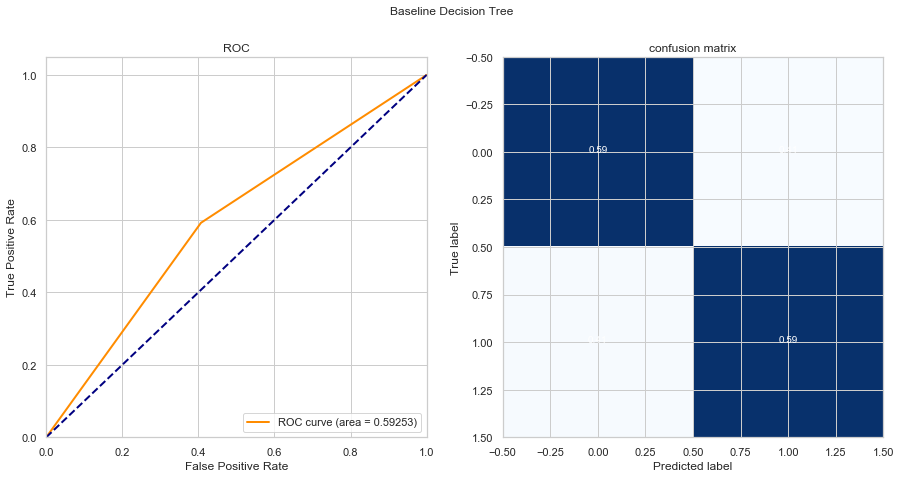

In [5]:
dt_base = DecisionTreeClassifier(max_depth = None)
dt_base.fit(X_train, y_train)

base_p = plot2graphs(dt_base, "Baseline Decision Tree")
print('Total Number of Predictors is %d' %np.sum(dt_base.feature_importances_ > 0))

### Decision Tree: Depth optimized

In [78]:
grid = [{'max_depth': list(range(3,9))}] 
uni_scorer_selector(DecisionTreeClassifier(random_state=42), grid, sco = "roc_auc")

Best scoring: 0.722 (+/-0.003) for {'max_depth': 6}


Total Number of Predictors is 15


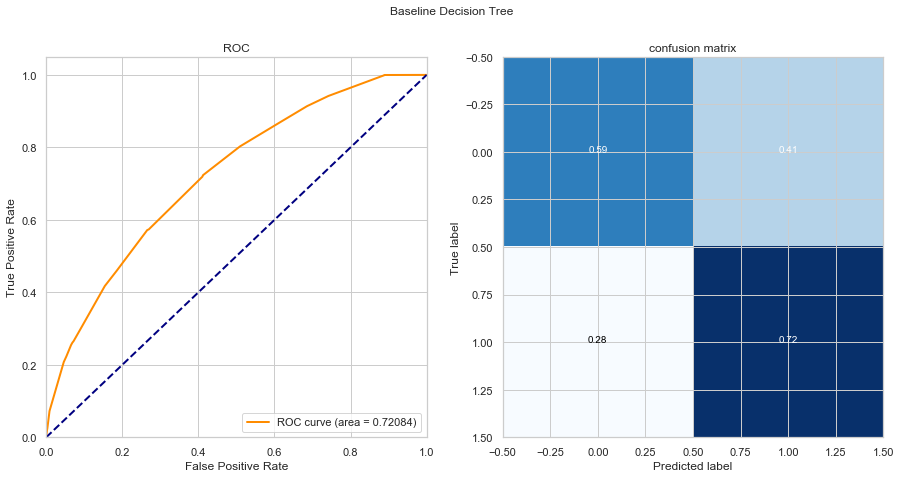

In [6]:
# fit decision tree with depth=6
dt_opt = DecisionTreeClassifier(max_depth = 6)
dt_opt.fit(X_train, y_train)
dt_opt_p = plot2graphs(dt_opt, "Baseline Decision Tree")
print('Total Number of Predictors is %d' %np.sum(dt_opt.feature_importances_ > 0))

### Random Forest: Grid Search for max_depth and n_estimators

In [53]:
grid = [{'n_estimators': [50, 100], 'max_depth': [10, 20]}] 
uni_scorer_selector(RandomForestClassifier(random_state=42), grid, sco = "roc_auc")

Best scoring: 0.744 (+/-0.006) for {'max_depth': 10, 'n_estimators': 100}


Total Number of Predictors is 76


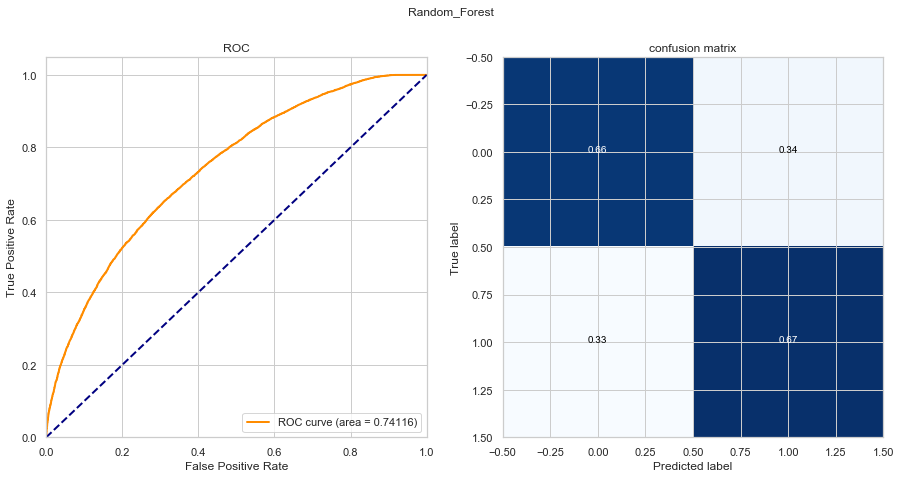

In [7]:
rf_opt = RandomForestClassifier(max_depth = 10, n_estimators=100).fit(X_train, y_train)
rf_opt_p = plot2graphs(rf_opt, "Random_Forest")
print('Total Number of Predictors is %d' %np.sum(rf_opt.feature_importances_ > 0))

### Losgistic Regression with L2 regularization

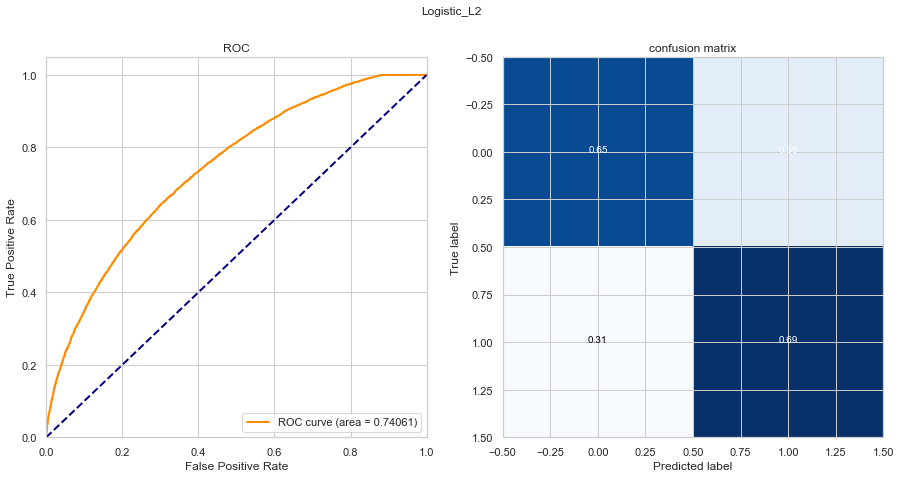

In [8]:
logreg = LogisticRegressionCV(penalty='l2',cv = 5, max_iter = 1000).fit(X_train,y_train)
logreg_p = plot2graphs(logreg, "Logistic_L2")

### Adaboost Classifier: Grid search on learning rate and n_estimators

In [73]:
grid = [{'n_estimators': [50, 100], 'learning_rate': [0.5,1]}] 
uni_scorer_selector(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2)), grid, sco = "roc_auc")

Best scoring: 0.688 (+/-0.013) for {'learning_rate': 0.5, 'n_estimators': 50}


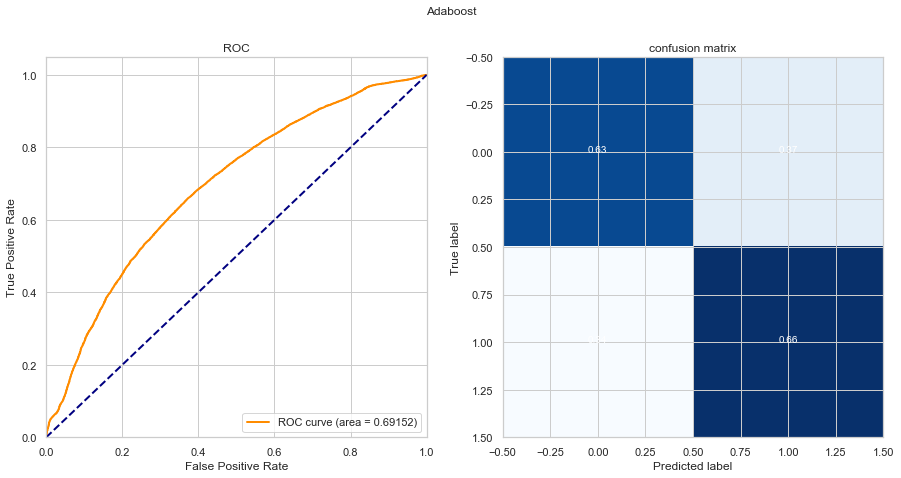

In [9]:
ada_opt = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 6), learning_rate=0.5, n_estimators=50).fit(X_train, y_train)
ada_opt_p = plot2graphs(ada_opt, "Adaboost")

### LDA, QDA: default setting

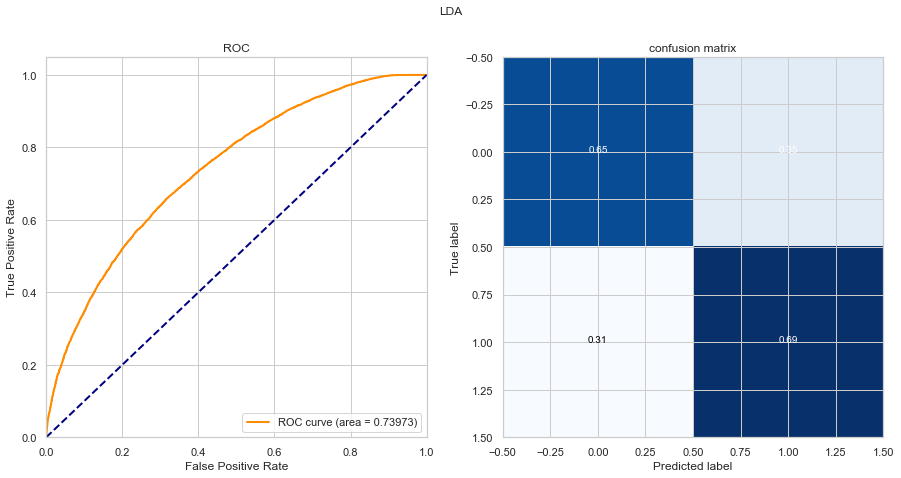

In [10]:
lda_model = LinearDiscriminantAnalysis().fit(X_train, y_train)
lda_p = plot2graphs(lda_model, "LDA")

/Users/Grace/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


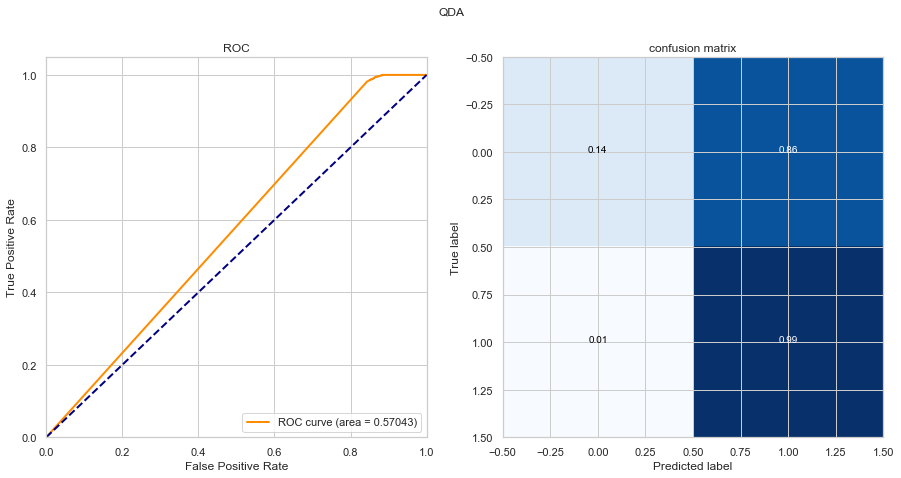

In [11]:
qda_model = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
qda_p = plot2graphs(qda_model, "QDA")

### Model stacking

In [12]:
from mlxtend.classifier import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
rf_model=RandomForestClassifier(n_estimators= 200, max_depth = 6)
ada_model=ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), 
                               n_estimators=50, learning_rate=0.01)
LDA_model=LinearDiscriminantAnalysis()
#KNN_model=KNeighborsClassifier(n_neighbors=20)
sclf = StackingClassifier(classifiers=[rf_model, ada_model,LDA_model], 
                          meta_classifier=LogisticRegression(),use_probas=True)
sclf.fit(X_train,y_train)

sclf_pred_train=sclf.predict(X_train)
sclf_pred_test=sclf.predict(X_test)
#performance Evaluation
sclf_train_score=accuracy_score(y_train, sclf_pred_train)*100
sclf_test_score=accuracy_score(y_test, sclf_pred_test)*100

print("sclf Accuracy on Training Set :",str(sclf_train_score)+'%')
print("sclf Accuracy on Testing Set :",str(sclf_test_score)+'%')

/Users/Grace/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


sclf Accuracy on Training Set : 67.91333333333334%
sclf Accuracy on Testing Set : 67.07%


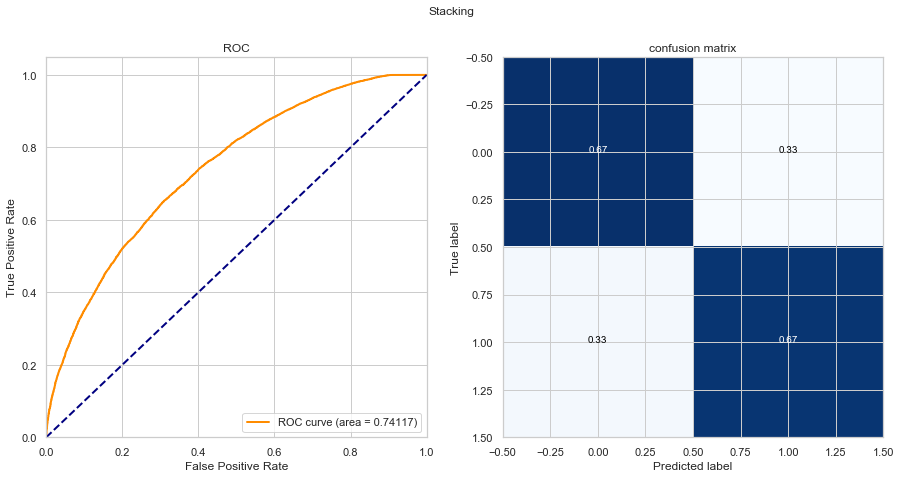

In [13]:
sclf_p = plot2graphs(sclf, "Stacking")

### Neural Network

**Neural Network Model Building Summary**

1.  Nodes per Layer: 200,100,40,1 ('output' layer)
- Activation function: ELU (Exponential linear unit). 
- Loss function: binary_crossentropy

- Output unit: Sigmoid 

- Optimizer: adamax (use default settings). 

- Epochs: 100
- Batch size: 100
- Validation size: .3
- EarlyStopping is applied to mitigate overfitting. If the validation accuracy does not increase on 20 epochs, the iteration will stop. 
- Add Gaussian Noise to mitigate overfitting, which could be seen as a form of random data augmentation. The method is found from the link: https://keras.io/layers/noise/
- At each layer, drop node randomly to mitigate overfitting. The weights are set to be 0.3, 0.3, 0.5 for the three layers, which are determined by grid search (code not included).

Additional explanations:

- We use `ELU` as the activation function, which speeds up learning, ensures a noise-robust deactivation state and leads to higher classification accuracies. Reference: Fast and Accurate Deep Network Learning by Exponential Linear Units (ELUs), https://arxiv.org/abs/1511.07289

- We use `adamax` as the optimizer, which is a special case of `adam`. 
`adam` is well suited for our problem where we have a large amount of data (n_train = 30,000) and parameters (p = 76) and the hyper-parameters have intuitive interpretation and typically require little tuning. `adamax` is more robust to noisy/sparse gradients compared with `adam`. Reference: 1. Adam: A Method for Stochastic Optimization, link: https://arxiv.org/pdf/1412.6980.pdf. 2. Gentle Introduction to the Adam Optimization Algorithm for Deep Learning, link: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/.


In [28]:
trials = {}

batch_size = 100
epochs = 100

input_dim = X_train.shape[1]

# reset the model 
NNmodel = Sequential()

# HIDDEN LAYER (new this time)
NNmodel.add(Dense(200, activation='elu', input_dim=input_dim,
                kernel_regularizer = regularizers.l2(0.000001), 
                activity_regularizer = regularizers.l1(0.0000001)))
NNmodel.add(Dropout(0.3))
# layer 1
NNmodel.add(Dense(100, activation='elu')) 
NNmodel.add(Dropout(0.3))
NNmodel.add(GaussianNoise(0.2))
# layer 2
NNmodel.add(Dense(40, activation='elu'))
NNmodel.add(Dropout(0.5))

# output layer
NNmodel.add(Dense(1, activation = 'sigmoid'))

# Summary 
NNmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 200)               15400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 40)                4040      
_________________________________________________________________
dropout_9 (Dropout)          (None, 40)                0         
__________

In [29]:
NNmodel.compile(optimizer='adamax',loss='binary_crossentropy', metrics=['accuracy'])
NNmodel_history = NNmodel.fit(X_train, y_train, 
                         epochs=epochs, shuffle = True, validation_split=0.3,
                         callbacks=[EarlyStopping(monitor='val_acc', patience = 20, mode = "max")], 
                         verbose=1)

Train on 21000 samples, validate on 9000 samples
Epoch 1/100
21000/21000 [==============================] - 3s 146us/step - loss: 0.6760 - acc: 0.6170 - val_loss: 0.6130 - val_acc: 0.6574
Epoch 2/100
21000/21000 [==============================] - 2s 104us/step - loss: 0.6318 - acc: 0.6464 - val_loss: 0.6022 - val_acc: 0.6651
Epoch 3/100
21000/21000 [==============================] - 2s 103us/step - loss: 0.6131 - acc: 0.6553 - val_loss: 0.5941 - val_acc: 0.6644
Epoch 4/100
21000/21000 [==============================] - 2s 108us/step - loss: 0.6034 - acc: 0.6644 - val_loss: 0.5895 - val_acc: 0.6713
Epoch 5/100
21000/21000 [==============================] - 2s 105us/step - loss: 0.5976 - acc: 0.6643 - val_loss: 0.5881 - val_acc: 0.6711
Epoch 6/100
21000/21000 [==============================] - 2s 108us/step - loss: 0.5917 - acc: 0.6681 - val_loss: 0.5867 - val_acc: 0.6721
Epoch 7/100
21000/21000 [==============================] - 2s 116us/step - loss: 0.5895 - acc: 0.6693 - val_loss: 0.5

In [21]:
from sklearn.externals import joblib
# dump to pickle
joblib.dump(NNmodel, 'NNmodel.pkl')

# and reload from pickle
NNmodel = joblib.load('NNmodel.pkl')

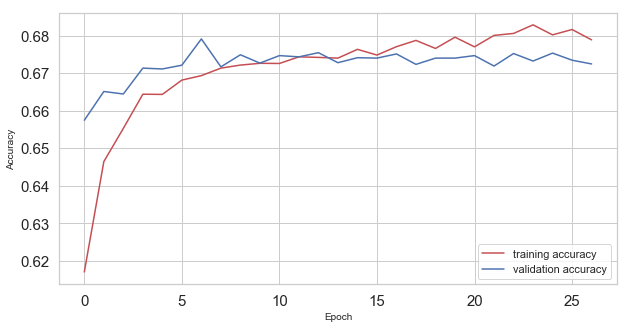

In [30]:
FIG_SIZE = (10,5)
FONT_SIZE = 10
LABEL_SIZE = 15

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax.plot(NNmodel_history.history['acc'], 'r',label = 'training accuracy')
ax.plot(NNmodel_history.history['val_acc'], 'b' ,label='validation accuracy')
ax.set_xlabel(r'Epoch', fontsize=FONT_SIZE)
ax.set_ylabel(r'Accuracy', fontsize=FONT_SIZE)
ax.legend()
ax.tick_params(labelsize=LABEL_SIZE)

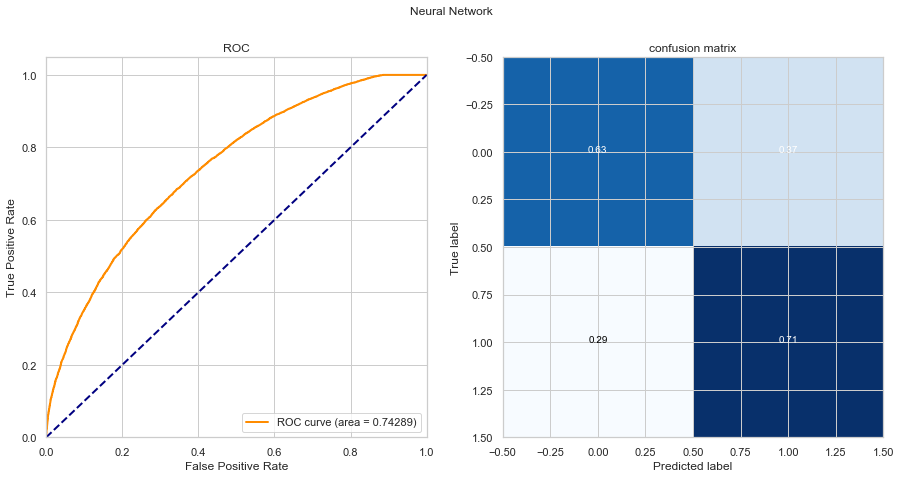

In [31]:
nn_p = plot2graphs(NNmodel, "Neural Network")

## Summary

### Featrue importances

/Users/Grace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/Users/Grace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/Grace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


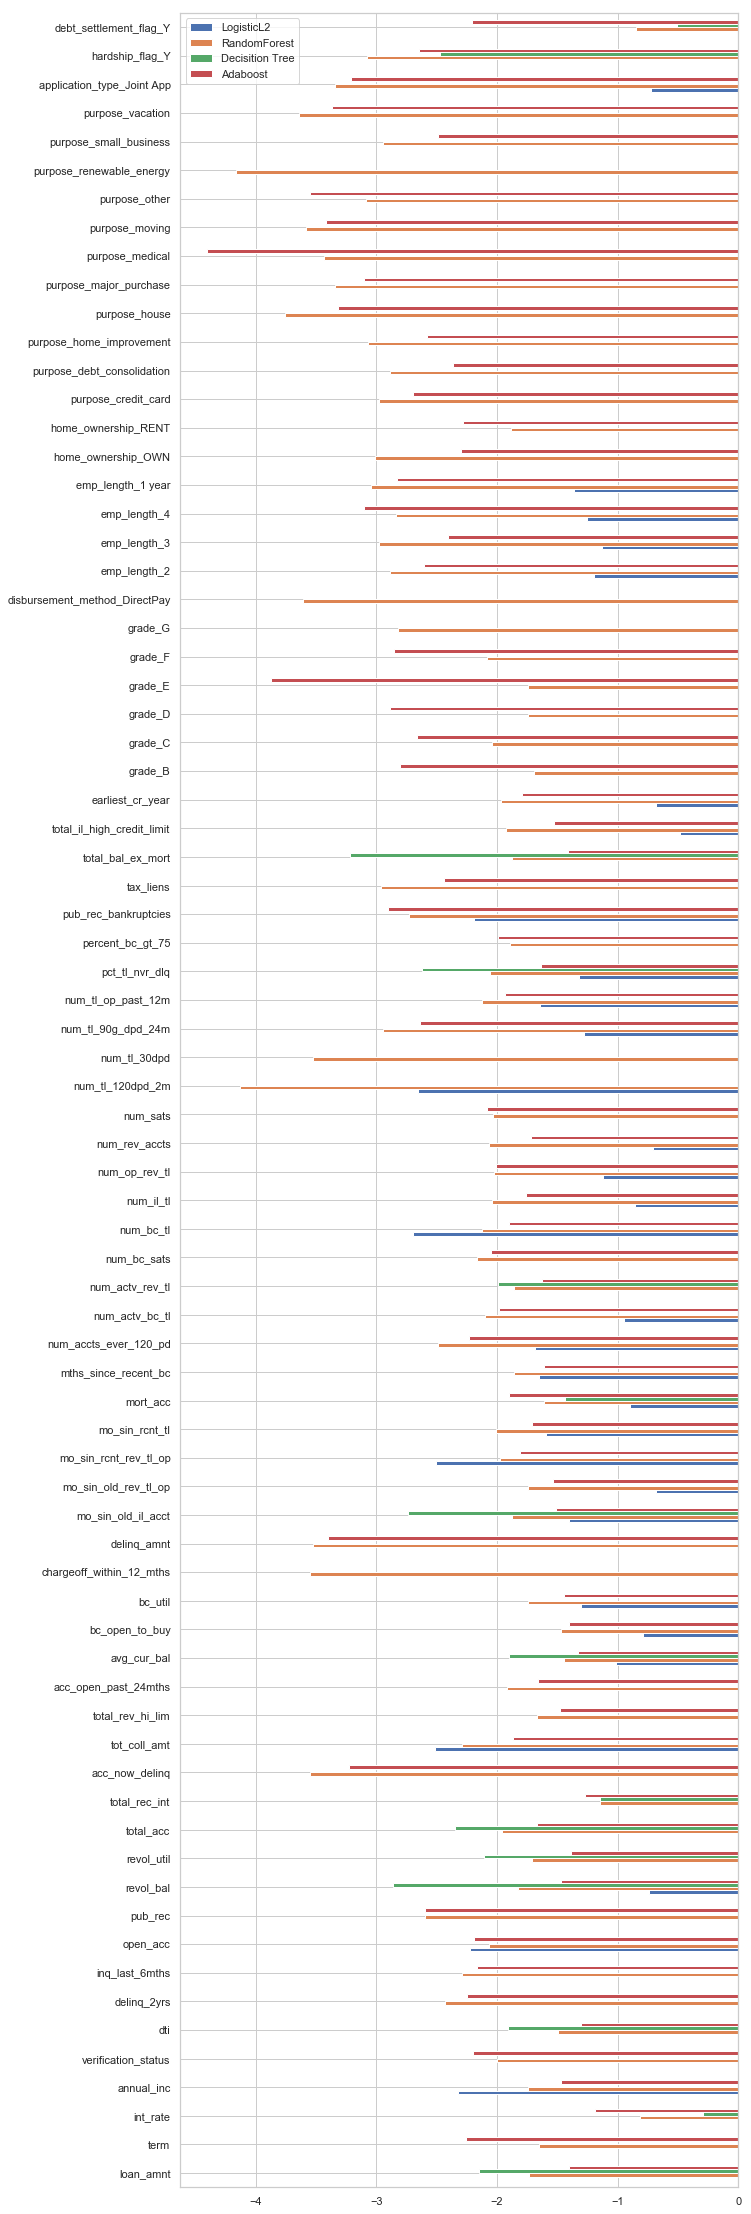

In [32]:
fnames =df_train.drop("loan_status", axis=1).columns.tolist()
fimp_logreg = logreg.coef_.ravel()
fimp_rf = rf_opt.feature_importances_
fimp_dtopt = dt_opt.feature_importances_
fimp_ada = ada_opt.feature_importances_
pd.DataFrame({
    "LogisticL2":np.log10(fimp_logreg + 0.000001),
    "RandomForest":np.log10(fimp_rf),
    "Decisition Tree":np.log10(fimp_dtopt),
    "Adaboost":np.log10(fimp_ada)
}, index = fnames).plot.barh(figsize = (10,40))

### Performance measures

In [33]:
# store models and performances
model_dict = {
    "Decision Tree": dt_opt,"Random Forest": rf_opt,
    "Logistic L2": logreg,"Adaboost": ada_opt,
    "LDA": lda_model,"QDA": qda_model,"stacking": sclf,
    "Neural Network": NNmodel
}

model_perf_dict = {
    "Decision Tree": dt_opt_p,"Random Forest": rf_opt_p,
    "Logistic L2": logreg_p,"Adaboost": ada_opt_p,
    "LDA": lda_p,"QDA": qda_p,"stacking": sclf_p,
    "Neural Network": nn_p
}
plist = []
for i in list(model_perf_dict.values()):
    plist.append(i[0])

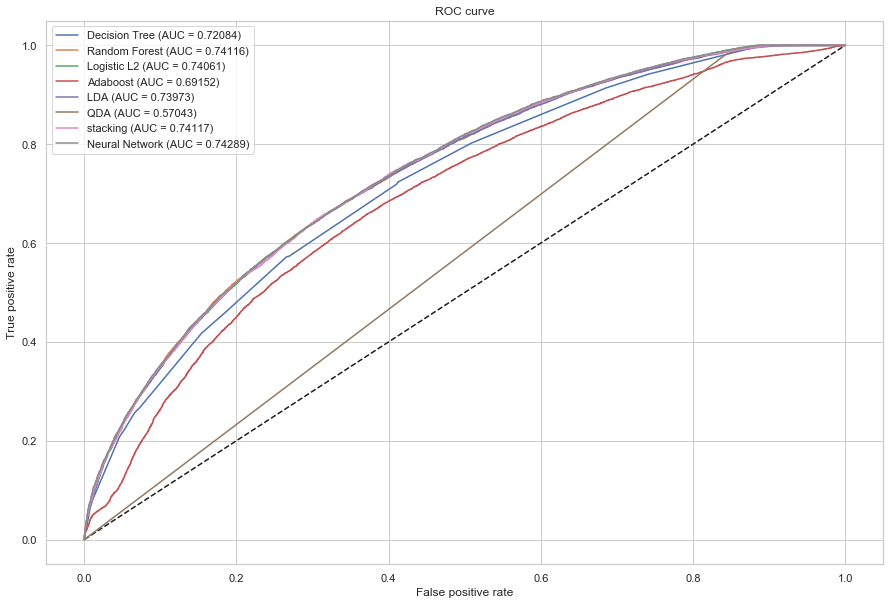

In [34]:
plt.figure(1, figsize = [15,10])

plt.plot([0, 1], [0, 1], 'k--')
for key in model_dict:
    plt.plot(model_perf_dict[key][1], model_perf_dict[key][2], 
             label='%s (AUC = %0.5f)' % (key, model_perf_dict[key][0][3]))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [35]:
pd.DataFrame(plist,index = model_perf_dict.keys(),
            columns=["Sensitivity", "Specificity", "Accuracy", "AUC"])

,Sensitivity,Specificity,Accuracy,AUC
Decision Tree,0.679553,0.637026,0.655433,0.720837
Random Forest,0.671424,0.668141,0.669767,0.741158
Logistic L2,0.676540,0.663309,0.669667,0.740612
Adaboost,0.648051,0.638907,0.643333,0.691520
LDA,0.676270,0.662060,0.668867,0.739732
QDA,0.930898,0.535307,0.565267,0.570428
stacking,0.669446,0.671973,0.670700,0.741173
Neural Network,0.684795,0.656828,0.669667,0.742890


Calculating the four properties, i.e., `Sensitivity`, `Specificity`, `Accuracy`, `AUC` of the eight different models, we could find that none of these models have significantly better performance compared to the others. "Random Forest", "Logistic Regression", "Stacking" and "Neural Network" have relatively higher "AUC" and "Accuracy" among the eight models. QDA has the lowest "AUC" but the highest "Sensitivity". "Boosting", "LDA" and single "Decision Tree" have relatively lower performance. 

In all the eight models, we predict the loan_status by comparing the estimated probability $\hat{p}$. 

If $\hat{p} > 0.5$, we predict it as 1, loan to invest. 

If $\hat{p} < 0.5$, we predict it as 0, loan not to invest. 

Here, 0.5 is the threshold of prediction, based on which we decide whether to invest or not. The prediction threshold may potential influence AUC and prediction accuracy, and in turn influence the benefit of investment. 

In the following analysis, we would like to find the best threshold of prediction to improve ROI and optimize our investing stategy. 

## Caluclate ROI and iROI

Based on our model, if one application's loan_status is predicted as 1, we will invest in this loan; otherwise, we won't. One of the popular ways to assess the benefit of investment is calculating the Return of Investment (ROI). The fomula of ROI is given by: 

**ROI = (Gain from Investment - Cost of Investment)/Cost of Investment**

The nominator **(Gain from Investment - Cost of Investment)** is also defined as the **net return on investment (NRI)**. 

For this problem, there are four different scenarios of predicted loan_status vs. true loan_status, as shown in the following table. We are using the `Loan Data` of 2016 from the website, including all the loan not declined, hence, all these applications are invested in real world. 

| Index | Category | Predicted Loan_status | True Loan_status | Whehter invested in real world|
| --- | --- | --- | --- | --- |
| 1 |Exact Gain| 1 | 1 | 1 |
| 2 |Exact Loss| 1 | 0 | 1 |
| 3 |Hidden Loss| 0 | 1 | 1 |
| 4 |Hidden Gain| 0 | 0 | 1 |

The four scenarios could also be classified as "True Positive", "False Positive", "False Negative", "True Negative" respectively. 

We define the amount of money we earned from the "True Positive" as `Exact Gain`, referring to the loan applications which were recorded fully paid and also predicted to invest in by the model. The amount of money we lost from the "False Positive" are defined as `Exact Loss`, referring to the loan applications which were not fully paid but predicted to invest in by the model. 

We also consider the two scenarios where the predicted loan_status is 0. If the loan applications were fully paid but not predicted to invest in by the model, we would lose the corresponding amount of money. On the other hand, if the loan applications were not fully paid and also not predicted to invest in by the model, we would avoid the loss and "rescue" the corresponding amount of money. These two cases are defined as `Hidden Loss` and `Hidden Gain`. 

We define the improved ROI (iROI) as the percent increase in ROI using the model investment strategy compared to the true ROI based on the `Loan Data` in 2016. The improved ROI (iROI) can be calculated by the following formula:

$$iROI = \frac{MNRI}{\sum \ funded\_amnt}$$

The **Model Net Return on Investment (MNRI)** is calculated as **(Exact Gain - Exact Loss)-(Hidden Loss- Hidden Gain) = Exact Return - Hidden Return**:

$$MNRI = \sum {I_{predicted}(Loan\_ status) \times (total\_pymnt - funded \_ amnt)} - \sum ({1-I_{predicted}(Loan\_ status)) \times (total\_pymnt - funded \_ amnt)}$$

The **Real Net Return on Investment (RNRI)** is calculated as **(True Gain - True Loss)**:

$$RNRI = \sum (total\_pymnt - funded\_pymnt)$$

We then use the grid search method to find the best threshold of prediction for each model to get the optimal iROI. 

Failing to include the two scenarios where the predicted loan_status is 0 would lead to lower net return and highly conservative models where only limited loan applications would be accepted. In this case, borrowers tend not to apply for loan at Leanding Club. Therefore, Lending Club would lose it customers and be less popular.

In [36]:
def LD_test_data_cleaning(df, scaler): # using the scaler from the training dataset
    
    # transform date
    dt_cols = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']
    df[dt_cols] = df[dt_cols].apply(pd.to_datetime, errors = 'coerce')
    
    df['issue_month'] = pd.DatetimeIndex(df['issue_d']).month
    df['issue_month'] = df['issue_month'].apply(lambda x: calendar.month_abbr[x])
    df['earliest_cr_year'] = pd.DatetimeIndex(df['earliest_cr_line']).year
    
    drop_cols = ["issue_d","earliest_cr_line", # extract the issue month and earliest credit year
                 "issue_month",'addr_state', "zip_code", # seems less important 
                                                         # might potentially impact the validation 
                                                         # of random forest
                 # columns related to the outcome
                 # unavialable information before the loan accepted
                 "last_pymnt_d","last_credit_pull_d",
                 "initial_list_status","out_prncp_inv",
                 "total_pymnt_inv","last_pymnt_amnt",
                 "total_pymnt", "funded_amnt", "installment", 
                 "total_rec_prncp","out_prncp",
                 
                 
                 # highly correlated to some other existing columns
                 "num_rev_tl_bal_gt_0",
                 "tot_cur_bal",
                 "tot_hi_cred_lim",
                 "total_bc_limit"]
    
    # transform employment year
    emp_length_dict = {"10+":4, '2':1, '3':1, '4':2, '5':2, '6':2, '7':3, '8':3,'9':3, '< 1 year':1}
    df = df.replace({"emp_length": emp_length_dict})
    
    df = df.drop(drop_cols, axis = 1)
    
    dummy_cols = ['grade',
                  'disbursement_method',
                  'emp_length',
                  'home_ownership',
                  'purpose',
                  'application_type',
                  'hardship_flag', 
                  'debt_settlement_flag',
                  'loan_status']
    
    #scale the non-binary covariates
    nonbinary_cols = df.columns.difference(dummy_cols)
    df[nonbinary_cols] = scaler.transform(df[nonbinary_cols])
    
    #transform the categorical columns to binary
    df = pd.get_dummies(df, columns = dummy_cols[:-1], drop_first = True)
    
    X= df.drop(["loan_status"],axis = 1).values
    y= df["loan_status"].values
    
    return df, X, y

In [37]:
# generate compatible full 2016 accepted data
acc = pd.read_csv("../Data/cdf_acc2016.csv")
acc_df, X_acc, y_acc = LD_test_data_cleaning(acc, train_scaler)

# full 2016 data to calculate ROI from funded amunt and total payment
df_loans = acc.iloc[acc_df.index,:][["funded_amnt","total_pymnt","loan_status"]]

/Users/Grace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [83]:
# calculate baseline return
net_gain = df_loans["total_pymnt"].values-df_loans["funded_amnt"].values
funded_amnt = df_loans["funded_amnt"].values
baseline_net_gain = np.sum(net_gain)
baseline_funded = np.sum(df_loans["funded_amnt"].values)
baseline_roi = np.sum(net_gain)/baseline_funded*100

In [84]:
def calc_roi(X_in, y_in, model_name, ifnaive = 0):
    
    # get the predicted probability from the model
    if model_name == "Neural Network":
        y_prob = model_dict[key].predict(X_acc).reshape(-1,)
    else: 
        y_prob = model_dict[model_name].predict_proba(X_in)[:,1]
        
    # grid search to find the best threshold/cutoff
    gain_list = []
    for i in  np.linspace(0, 0.90, 90):
        y_give = (y_prob >= i).astype("int")
        y_notgive = 1-y_give
        
        # for those who are predicted to return money
        exact_return = np.sum(net_gain*y_give)
        # for those who are predicted not to return money
        hidden_return = np.sum(net_gain*y_notgive)
        
        loan_funded = np.sum(y_give*funded_amnt)
        
        if ifnaive == 0:
            gain = exact_return/loan_funded
        else:
            gain = (exact_return-hidden_return)/baseline_funded
        gain_list.append(gain*100)
    
    #find the best threshold's corresponding index and store it in the list
    best_index = np.argmax(gain_list)
    best_gain = gain_list[best_index]
    best_cutoff = best_index*0.01
    
    # calculating the accepted rate, the proportion of loan applications accepted by our new model
    y_pred = (y_prob >= best_cutoff).astype("int")
    acc_rate = y_pred.mean()
    
    # confusion matrix
    cm = confusion_matrix(y_in, y_pred)
    TP, TN, FP, FN = cm[0][0], cm[1][1], cm[0][1], cm[1][0]
    
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    
    #calculate the roc_auc
    roc_auc = roc_auc_score(y_in, y_prob)
    
    p =  [best_gain, best_cutoff, sensitivity, specificity, accuracy, roc_auc, acc_rate]
    
    return gain_list, best_index, p

### ROI

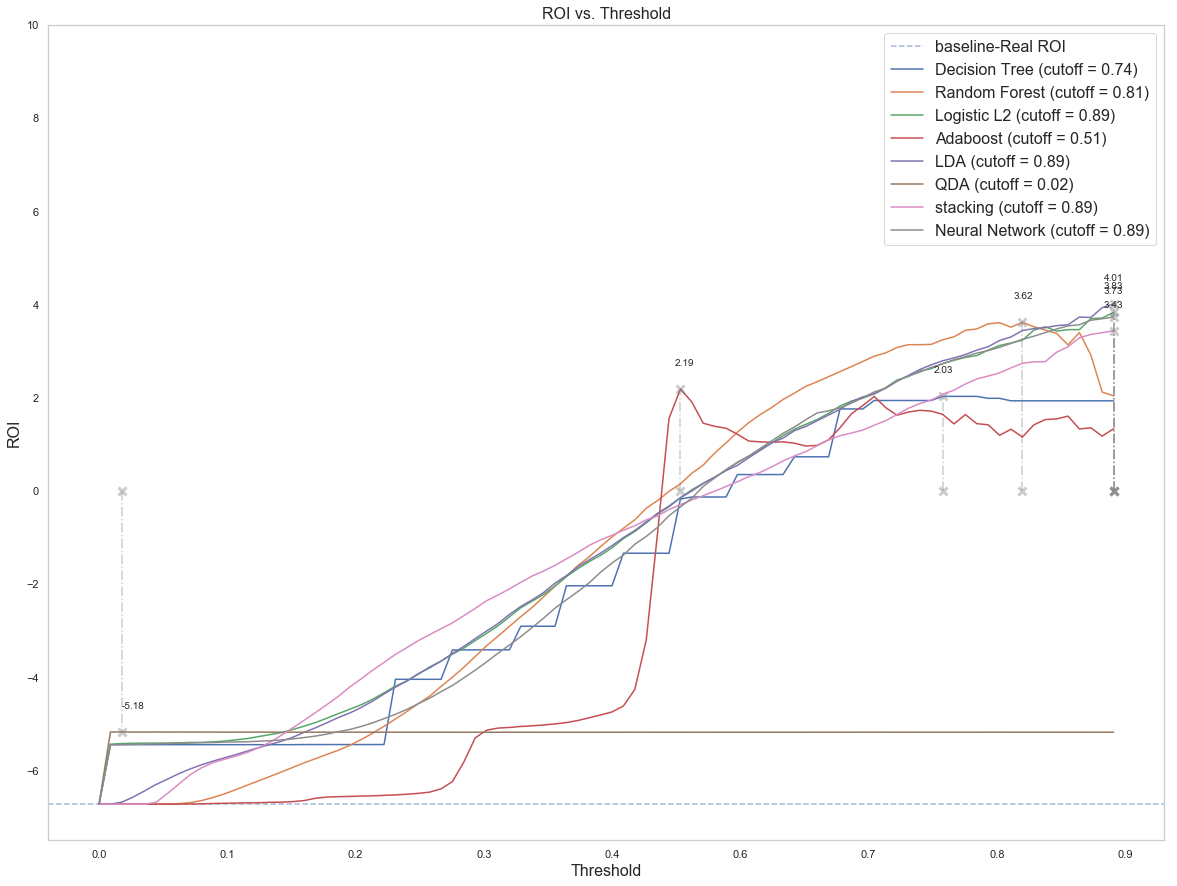

In [96]:
roi_dict = {}

plt.figure(figsize = (20,15))
plt.ylim([-7.5,10])
plt.grid(False)
plt.axis('on')
plt.axhline(y = baseline_roi, linestyle="--",label = "baseline-Real ROI", alpha = 0.5)

for key in model_dict:
    rates, best_index, roi_dict[key] = calc_roi(X_acc, y_acc, key)
    best_gain = roi_dict[key][0]
    plt.plot(rates, label = '%s (cutoff = %0.2f)' % (key, best_index*0.01))
    plt.plot([best_index, ] * 2, [0, best_gain], alpha=0.4,
             linestyle='-.', color="grey", marker='x', markeredgewidth=3, ms=8)
    plt.annotate("%0.2f" % best_gain,
                (best_index*(1-0.01), best_gain+0.5))
plt.legend(fontsize = 16)
plt.xticks(np.linspace(0, 90, 9), np.round(np.linspace(0, 1, 10),1) )
plt.xlabel("Threshold",fontsize = 16)
plt.ylabel("ROI",fontsize = 16)
plt.title("ROI vs. Threshold",fontsize = 16)
plt.show()

In [86]:
roi_col_names = ["ROI", "Threshold", "sensitivity", "specificity","accuracy", "ROC_AUC", "Accepted Rate"]

roi_df = pd.DataFrame.from_dict(roi_dict, orient='index', columns = roi_col_names)

In [87]:
roi_df

,ROI,Threshold,sensitivity,specificity,accuracy,ROC_AUC,Accepted Rate
Decision Tree,2.027476,0.74,0.334644,0.913666,0.453766,0.727954,0.205730
Random Forest,3.616724,0.81,0.293583,0.975353,0.318993,0.763520,0.037271
Logistic L2,3.830847,0.89,0.291113,0.968435,0.310825,0.748555,0.029103
Adaboost,2.186434,0.51,0.371040,0.889698,0.545057,0.737342,0.335513
LDA,4.010311,0.89,0.289501,0.972222,0.305000,0.747603,0.022702
QDA,-5.175743,0.02,0.851644,0.744913,0.750007,0.571984,0.952272
stacking,3.433836,0.89,0.290394,0.974413,0.308049,0.749502,0.025811
Neural Network,3.729304,0.89,0.297757,0.965476,0.333770,0.752707,0.053935


In [88]:
roi_df.to_csv("../Data/cdf_roi.csv")

### iROI

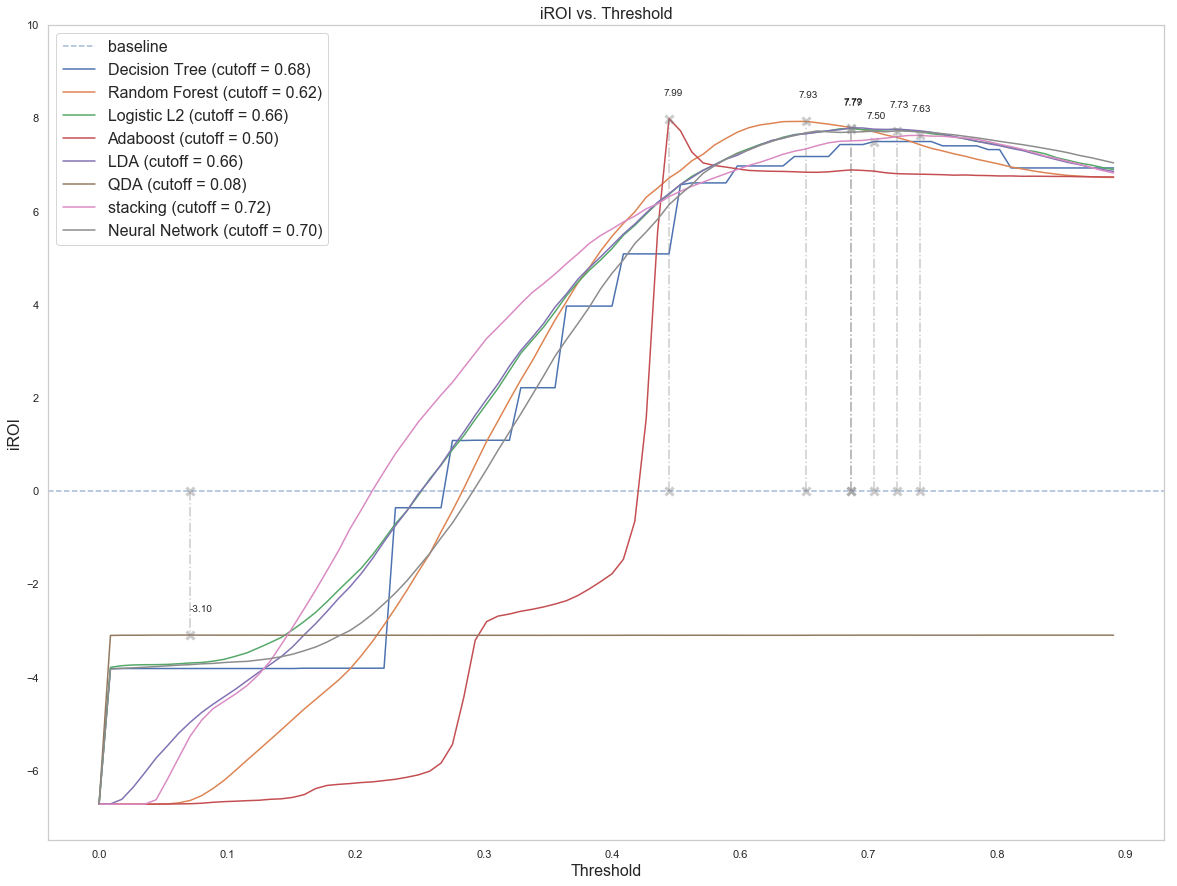

In [97]:
iroi_dict = {}

plt.figure(figsize = (20,15))
plt.ylim([-7.5,10])
plt.grid(False)
plt.axis('on')
plt.axhline(y = 0, linestyle="--",label = "baseline", alpha = 0.5)

for key in model_dict:
    rates, best_index, iroi_dict[key] = calc_roi(X_acc, y_acc, key, ifnaive = 1)
    best_gain = iroi_dict[key][0]
    plt.plot(rates, label = '%s (cutoff = %0.2f)' % (key, best_index*0.01))
    plt.plot([best_index, ] * 2, [0, best_gain], alpha=0.4,
             linestyle='-.', color="grey", marker='x', markeredgewidth=3, ms=8)
    plt.annotate("%0.2f" % best_gain,
                (best_index*(1-0.01), best_gain+0.5))
plt.legend(fontsize = 16)
plt.xticks(np.linspace(0, 90, 9), np.round(np.linspace(0, 1, 10),1))
plt.xlabel("Threshold",fontsize = 16)
plt.ylabel("iROI",fontsize = 16)
plt.title("iROI vs. Threshold",fontsize = 16)
plt.show()

In [90]:
iroi_col_names = ["iROI", "Threshold", "sensitivity", "specificity","accuracy", "ROC_AUC", "Accepted Rate"]
iroi_df = pd.DataFrame.from_dict(iroi_dict, orient='index', columns = iroi_col_names)
display(iroi_df)

,iROI,Threshold,sensitivity,specificity,accuracy,ROC_AUC,Accepted Rate
Decision Tree,7.496681,0.68,0.335601,0.911756,0.456820,0.727954,0.210393
Random Forest,7.928867,0.62,0.369777,0.908165,0.536784,0.763520,0.310199
Logistic L2,7.773277,0.66,0.364684,0.895965,0.530041,0.748555,0.311242
Adaboost,7.989183,0.50,0.456881,0.842002,0.680213,0.737342,0.579900
LDA,7.791632,0.66,0.366830,0.893528,0.535285,0.747603,0.319832
QDA,-3.095161,0.08,0.844826,0.744938,0.749764,0.571984,0.951681
stacking,7.628692,0.72,0.355226,0.902942,0.507269,0.749502,0.277596
Neural Network,7.725996,0.70,0.347634,0.912778,0.486688,0.752707,0.246050


In [91]:
iroi_df.to_csv("../Data/cdf_iroi.csv")

In [92]:
def update_y_pred(X_in, model_name, cutoff):
    if model_name == "Neural Network":
        y_prob = model_dict[key].predict(X_acc).reshape(-1,)
    else: 
        y_prob = model_dict[model_name].predict_proba(X_in)[:,1]
        
    return (y_prob >= cutoff).astype("int")

In [93]:
rf_select = ["purpose","emp_length", "num_tl_120dpd_2m", "acc_now_delinq"]
most_select = ["annual_inc","revol_bal","avg_cur_bal","mo_sin_old_il_acct", "mort_acc","pct_tl_nvr_dlq"]
discrimination_col_names = rf_select + most_select + ["addr_state","funded_amnt","total_pymnt","loan_status"]

In [94]:
roi_discrimination = acc.loc[:, discrimination_col_names]
rf_cutoff = roi_dict["Random Forest"][1]
roi_discrimination["Random_Forest"] = update_y_pred(X_acc, "Random Forest", rf_cutoff)
nn_cutoff = roi_dict["Neural Network"][1]
roi_discrimination["Neural_Network"] = update_y_pred(X_acc, "Neural Network", nn_cutoff)
roi_discrimination.to_csv("../Data/roi_discrimination.csv")
display(roi_discrimination.head(10))

,purpose,emp_length,num_tl_120dpd_2m,acc_now_delinq,annual_inc,revol_bal,avg_cur_bal,mo_sin_old_il_acct,mort_acc,pct_tl_nvr_dlq,addr_state,funded_amnt,total_pymnt,loan_status,Random_Forest,Neural_Network
0,debt_consolidation,10+,0,0,195000.0,32223,71635,122,4,88.5,NM,35000,47748.356466,1,0,0
1,debt_consolidation,8,0,0,105000.0,6219,3361,124,0,95.2,MD,16000,16098.340000,1,0,1
2,home_improvement,10+,0,0,90000.0,19386,7966,180,3,100.0,ND,9000,9361.741129,1,1,1
3,credit_card,2,0,0,79000.0,7787,15052,138,2,95.7,OK,13550,15537.174857,1,0,0
4,debt_consolidation,4,0,0,70000.0,24472,22071,159,2,100.0,IN,10000,10924.386145,1,0,0
5,debt_consolidation,8,0,0,30388.8,5546,14577,45,2,100.0,KS,7500,8668.809884,1,0,0
6,car,10+,0,0,197000.0,762,7937,132,1,100.0,MI,7200,7954.533952,1,0,0
7,debt_consolidation,10+,0,0,120000.0,30323,10973,163,2,98.3,NY,30000,34759.900019,1,0,0
8,debt_consolidation,10+,0,0,80000.0,13223,3683,142,0,100.0,CA,25000,26849.046949,1,0,0
9,debt_consolidation,10+,0,0,69000.0,5424,2585,119,0,91.7,FL,6000,4401.370000,0,0,0


In [95]:
iroi_discrimination = acc.loc[:, discrimination_col_names]
rf_cutoff = iroi_dict["Random Forest"][1]
iroi_discrimination["Random_Forest"] = update_y_pred(X_acc, "Random Forest", rf_cutoff)
nn_cutoff = iroi_dict["Neural Network"][1]
iroi_discrimination["Neural_Network"] = update_y_pred(X_acc, "Neural Network", nn_cutoff)
iroi_discrimination.to_csv("../Data/iroi_discrimination.csv")
display(iroi_discrimination.head(10))

,purpose,emp_length,num_tl_120dpd_2m,acc_now_delinq,annual_inc,revol_bal,avg_cur_bal,mo_sin_old_il_acct,mort_acc,pct_tl_nvr_dlq,addr_state,funded_amnt,total_pymnt,loan_status,Random_Forest,Neural_Network
0,debt_consolidation,10+,0,0,195000.0,32223,71635,122,4,88.5,NM,35000,47748.356466,1,0,0
1,debt_consolidation,8,0,0,105000.0,6219,3361,124,0,95.2,MD,16000,16098.340000,1,1,1
2,home_improvement,10+,0,0,90000.0,19386,7966,180,3,100.0,ND,9000,9361.741129,1,1,1
3,credit_card,2,0,0,79000.0,7787,15052,138,2,95.7,OK,13550,15537.174857,1,0,0
4,debt_consolidation,4,0,0,70000.0,24472,22071,159,2,100.0,IN,10000,10924.386145,1,1,1
5,debt_consolidation,8,0,0,30388.8,5546,14577,45,2,100.0,KS,7500,8668.809884,1,0,0
6,car,10+,0,0,197000.0,762,7937,132,1,100.0,MI,7200,7954.533952,1,1,1
7,debt_consolidation,10+,0,0,120000.0,30323,10973,163,2,98.3,NY,30000,34759.900019,1,0,0
8,debt_consolidation,10+,0,0,80000.0,13223,3683,142,0,100.0,CA,25000,26849.046949,1,1,1
9,debt_consolidation,10+,0,0,69000.0,5424,2585,119,0,91.7,FL,6000,4401.370000,0,0,0
